In [1]:
from abc import ABC, abstractmethod
import math
import numpy as np
import torch
from torch import utils
from torch import nn
from torch import optim
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToPILImage
from IPython.display import Image

### diffusion model example

In [2]:
data_dir = '/Users/armandli/data/'

In [3]:
to_img = ToPILImage()

In [4]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_built()
if use_cuda:
    device = torch.device('cuda')
elif use_mps:
    #mps has bugs that cannot handle ConvTranspose2d, reverting to cpu
    #device = torch.device('mps')
    device = torch.device('cpu')
else:
    device = torch.device('cpu')
cpu = torch.device('cpu')

In [5]:
default_batch_size = 256
loader_args = {'batch_size' : default_batch_size, 'shuffle' : True}
score_args = {'batch_size' : default_batch_size, 'shuffle' : False}
if use_cuda:
    loader_args.update({'pin_memory' : True})
    score_args.update({'pin_memory' : True})

In [6]:
class Reporter(ABC):
    @abstractmethod
    def report(self, typ, **metric):
        pass
    @abstractmethod
    def reset(self):
        pass

In [7]:
class SReporter(Reporter):
    def __init__(self):
        self.log = []
    def report(self, typ, **data):
        self.log.append((typ, data))
    def reset(self):
        self.log.clear()
    def loss(self, t):
        losses = []
        for (typ, data) in self.log:
            if typ == t:
                losses.append(data['loss'])
        return losses
    def loss(self, t, idx):
        if idx >= 0:
            count = 0
            for (typ, data) in self.log:
                if typ == t:
                    if count == idx:
                        return data['loss']
                    count += 1
        else:
            count = -1
            for (typ, data) in reversed(self.log):
                if typ == t:
                    if count == idx:
                        return data['loss']
                    count -= 1
        return float("inf")
    def eval_loss(self):
        return self.loss('eval')
    def train_loss(self):
        return self.loss('train')
    def eval_loss(self, idx):
        return self.loss('eval', idx)
    def train_loss(self, idx):
        return self.loss('train', idx)
    def get_record(self, t, idx):
        if idx >= 0:
            count = 0
            for (typ, data) in self.log:
                if typ == t:
                    if count == idx:
                        return data
                    count += 1
        else:
            count = -1
            for (typ, data) in reversed(self.log):
                if typ == t:
                    if count == idx:
                        return data
                    count -= 1
        return dict()
    def eval_record(self, idx):
        return self.get_record('eval', idx)
    def train_record(self, idx):
        return self.get_record('train', idx)

In [8]:
class TimeEmbeddingV1(nn.Module):
    def __init__(self, cdim):
        super(TimeEmbeddingV1, self).__init__()
        self.cdim = cdim
        self.layers = nn.Sequential(
            nn.Linear(self.cdim//4, self.cdim),
            nn.SiLU(),
            nn.Linear(self.cdim, self.cdim),
        )
    
    def forward(self, t):
        half_dim = self.cdim // 8
        emb = math.log(10_000) / (half_dim-1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:,None] * emb[None,:]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        emb = self.layers(emb)
        return emb


In [9]:
class ResidualBlockV1(nn.Module):
    def __init__(self, cdim_in, cdim_out, tdim, gdim=32, dropout=0.1):
        super(ResidualBlockV1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.GroupNorm(gdim, cdim_in),
            nn.SiLU(),
            nn.Conv2d(cdim_in, cdim_out, kernel_size=(3,3), padding=(1,1)),
        )
        self.layer2 = nn.Sequential(
            nn.GroupNorm(gdim, cdim_out),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(cdim_out, cdim_out, kernel_size=(3,3), padding=(1,1)),
        )
        self.time_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(tdim, cdim_out),
        )
        if cdim_in != cdim_out:
            self.skip = nn.Conv2d(cdim_in, cdim_out, kernel_size=(1,1))
        else:
            self.skip = nn.Identity()
    
    def forward(self, x, t):
        h = self.layer1(x)
        h += self.time_layer(t)[:,:,None,None] #TODO: understand this
        h = self.layer2(h)
        return h + self.skip(x)

In [10]:
class UpSampleV1(nn.Module):
    def __init__(self, cdim):
        super(UpSampleV1, self).__init__()
        self.layer = nn.ConvTranspose2d(cdim, cdim, (4, 4), (2,2), (1,1))
    
    def forward(self, x, t):
        return self.layer(x)

In [11]:
class DownSampleV1(nn.Module):
    def __init__(self, cdim):
        super(DownSampleV1, self).__init__()
        self.layer = nn.Conv2d(cdim, cdim, (3,3),(2,2),(1,1))
    
    def forward(self, x, t):
        return self.layer(x)

In [12]:
class DDPMV1(nn.Module):
    def __init__(self, cdim_in=3, cdim=64, cmults=(1,2,2,4), n_blocks=2):
        super(DDPMV1, self).__init__()
        n = len(cmults)
        self.time_emb = TimeEmbeddingV1(cdim*4)
        self.image_proj = nn.Conv2d(cdim_in, cdim, kernel_size=(3,3), padding=(1,1))
        down = []
        out_channels = in_channels = cdim
        for i in range(n):
            out_channels = in_channels * cmults[i]
            for _ in range(n_blocks):
                down.append(ResidualBlockV1(in_channels, out_channels, cdim*4))
                in_channels = out_channels
            down.append(DownSampleV1(in_channels))
        self.down = nn.ModuleList(down)
        self.middle = ResidualBlockV1(out_channels, out_channels, cdim*4)
        up = []
        in_channels = out_channels
        for i in reversed(range(n)):
            up.append(UpSampleV1(in_channels))
            out_channels = in_channels // cmults[i]
            up.append(ResidualBlockV1(in_channels+out_channels*cmults[i], out_channels, cdim*4))
            for _ in range(1, n_blocks):
                up.append(ResidualBlockV1(out_channels, out_channels, cdim*4))
            in_channels = out_channels
        self.up = nn.ModuleList(up)
        self.final = nn.Sequential(
            nn.GroupNorm(8, cdim),
            nn.SiLU(),
            nn.Conv2d(in_channels, cdim_in, kernel_size=(3,3), padding=(1,1)),
        )

    def forward(self, x, t):
        t = self.time_emb(t)
        x = self.image_proj(x)
        h = []
        for m in self.down:
            if isinstance(m, DownSampleV1):
                h.append(x)
            x = m(x, t)
        x = self.middle(x, t)
        is_first = False
        for m in self.up:
            if isinstance(m, UpSampleV1):
                x = m(x, t)
                is_first = True
            else:
                if is_first:
                    s = h.pop()
                    x = torch.cat((x, s), dim=1)
                    is_first = False
                x = m(x, t)
        return self.final(x)

In [13]:
### datasets

In [14]:
dataset = datasets.MNIST(root=data_dir, transform=transforms.ToTensor(), download=True)

In [15]:
dataset = datasets.CIFAR10(root=data_dir, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified


In [16]:
len(dataset)

50000

In [17]:
shape = dataset[0][0].unsqueeze(0).shape
shape

torch.Size([1, 3, 32, 32])

In [18]:
loader = utils.data.DataLoader(dataset, **loader_args)

In [19]:
model = DDPMV1(cdim_in=3, cdim=32, cmults=(1,2), n_blocks=1)
model = model.to(device)

In [20]:
T = 1024
learning_rate = 0.0001
total_epochs = 2
optimizer = optim.Adam(model.parameters(recurse=True), lr=learning_rate)
loss = nn.MSELoss()
reporter = SReporter()

In [21]:
beta = torch.linspace(0.0001, 0.02, T)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0).to(device)
sigma2 = beta

In [22]:
def q_xt_x0(x0, t, alpha_bar):
    mean = alpha_bar.gather(-1, t).reshape(-1, 1, 1, 1) ** 0.5 * x0
    var = 1 - alpha_bar.gather(-1, t).reshape(-1, 1, 1, 1)
    return mean, var

In [23]:
def q_sample(x0, t, alpha_bar, eps=None):
    if eps is None:
        eps = torch.randn_like(x0)
    mean, var = q_xt_x0(x0, t, alpha_bar)
    return mean + (var ** 0.5) * eps

In [24]:
def p_sample(xt, eps_theta, device, t, alpha_bars, alphas, sigma2s):
    noise = torch.randn(xt.shape, device=device) if t != 0 else torch.zeros(xt.shape)
    alpha_bar = alpha_bars.gather(-1, t)
    alpha = alphas.gather(-1, t)
    eps_coef = (1. - alpha) / (1 - alpha_bar) ** 0.5
    var = sigma2s.gather(-1, t)
    mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
    return mean + (var ** 0.5) * noise

In [25]:
def diffusion_train(model, device, loader, optimizer, loss, T, alpha_bar, epoch, reporter):
    model.train()
    total_loss = 0.
    for (x0, _) in loader:
        optimizer.zero_grad()
        x0 = x0.to(device)
        # create xt
        batch_size = x0.shape[0]
        t = torch.randint(0, T, (batch_size,), device=device, dtype=torch.long)
        noise = torch.rand_like(x0)
        xt = q_sample(x0, t, alpha_bar, noise)
        # compute backward noise prediction epsilon_theta
        eps_theta = model(xt, t)
        # compute loss between true noise and predicted noise
        l = loss(noise, eps_theta)
        l.backward()
        optimizer.step()
        total_loss += l.item()
    total_loss /= float(len(loader.dataset))
    reporter.report(typ='train', loss=total_loss)
    print(f"Train Loss: {total_loss}")

In [26]:
def diffusion_sample(model, device, shape, T, alpha_bars, alphas, sigma2s):
    xt = torch.randn(shape).to(device)
    for i in reversed(range(T)):
        t = torch.tensor(i, device=device).repeat(shape[0]) #TODO: dimension correct ?
        eps_theta = model(xt, t)
        xt = p_sample(xt, eps_theta, device, t, alpha_bars, alphas, sigma2s)
    return xt

In [27]:
def diffusion_train_sample(model, device, loader, optimizer, loss, T, shape, alpha_bars, alphas, sigma2s, total_epochs, reporter):
    for epoch in range(total_epochs):
        diffusion_train(model, device, loader, optimizer, loss, T, alpha_bars, epoch, reporter)
        x = diffusion_sample(model, device, shape, T, alpha_bars, alphas, sigma2s)
        #to_img(x[0]) #TODO: not working

In [28]:
diffusion_train_sample(model, device, loader, optimizer, loss, T, shape, alpha_bar, alpha, sigma2, total_epochs, reporter)

Train Loss: 0.0002475642381235957
Train Loss: 8.592225775122643e-05


In [29]:
x = diffusion_sample(model, device, shape, T, alpha_bar, alpha, sigma2)

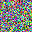

In [33]:
to_img(x[0])